In [1]:
import torch
import sys
home_dir = "/Users/jdli/Project/kurucz1/"
sys.path.append(home_dir)  # Adjust the path to include the parent directory
from kuruczone import emulator

# Load pre-trained model
model = emulator.load_from_checkpoint(home_dir+"checkpoints_0426_temp/best_model.pt",
                                      dataset_path=home_dir+"/data/kurucz_v4.pt",
                                      device='mps')

# Create stellar parameter inputs
stellar_params = torch.tensor([[5000.0, 4.5, -0.5, 0.0]])  # Teff, log(g), [Fe/H], [α/Fe]

# Create optical depth grid
tau_grid = torch.logspace(-6, 2, 80).unsqueeze(0)  # Shape: [1, 100]

# Predict atmospheric structure
atmosphere = model.predict(stellar_params, tau_grid)


/Users/jdli/Project/kurucz1/dataset.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(filepath, map_location=device)
/Users/jdli/Project/kurucz1/k

Model loaded: trained for 233 epochs, final loss: 0.002079


In [6]:
import torch
import sys
import time
home_dir = "/Users/jdli/Project/kurucz1/"
sys.path.append(home_dir)  # Adjust the path to include the parent directory
from kuruczone import emulator

# Check for MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device.")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU instead.")

# Load pre-trained model and move it to the selected device
model = emulator.load_from_checkpoint(home_dir+"checkpoints_0426_temp/best_model.pt",
                                      dataset_path=home_dir+"/data/kurucz_v4.pt", 
                                      device=device )

# Define a single stellar parameter set and optical depth grid
# These will be moved to the device inside the loop
single_stellar_param = torch.tensor([[5000.0, 4.5, -0.5, 0.0]])  # Teff, log(g), [Fe/H], [α/Fe]
single_tau_grid = torch.logspace(-6, 2, 80).unsqueeze(0)      # Shape: [1, 80]

# List of number of models to generate
num_models_list = [50, 100, 1000, 5000] # Added 100000 as in your latest snippet
time_cost_mps = []

print("Calculating time cost for generating multiple atmosphere models:")

for num_models in num_models_list:
    # Create batch stellar parameter inputs
    stellar_params_batch = single_stellar_param.repeat(num_models, 1).to(device) # Move to device

    # Create batch optical depth grid
    tau_grid_batch = single_tau_grid.repeat(num_models, 1).to(device) # Move to device

    # Predict atmospheric structure and measure time
    start_time = time.time()
    with torch.no_grad(): # Disable gradient calculations for inference
        atmosphere_batch = model.predict(stellar_params_batch, tau_grid_batch)
    end_time = time.time()

    execution_time = end_time - start_time
    time_cost_mps.append(execution_time)
    print(f"Time taken to generate {num_models} model(s) on {device}: {execution_time:.4f} seconds")


Using MPS device.
Model loaded: trained for 233 epochs, final loss: 0.002079
Calculating time cost for generating multiple atmosphere models:
Time taken to generate 50 model(s) on mps: 0.8170 seconds
Time taken to generate 100 model(s) on mps: 0.0311 seconds
Time taken to generate 1000 model(s) on mps: 0.0589 seconds
Time taken to generate 5000 model(s) on mps: 0.1337 seconds


In [7]:
import torch
import sys
import time
home_dir = "/Users/jdli/Project/kurucz1/"
sys.path.append(home_dir)  # Adjust the path to include the parent directory
from kuruczone import emulator

device = torch.device("cpu")

# Load pre-trained model and move it to the selected device
model = emulator.load_from_checkpoint(home_dir+"checkpoints_0426_temp/best_model.pt",
                                      dataset_path=home_dir+"/data/kurucz_v4.pt", 
                                      device=device )

# Define a single stellar parameter set and optical depth grid
# These will be moved to the device inside the loop
single_stellar_param = torch.tensor([[5000.0, 4.5, -0.5, 0.0]])  # Teff, log(g), [Fe/H], [α/Fe]
single_tau_grid = torch.logspace(-6, 2, 80).unsqueeze(0)      # Shape: [1, 80]

# List of number of models to generate
time_cost_cpu = []

print("Calculating time cost for generating multiple atmosphere models:")

for num_models in num_models_list:
    # Create batch stellar parameter inputs
    stellar_params_batch = single_stellar_param.repeat(num_models, 1).to(device) # Move to device

    # Create batch optical depth grid
    tau_grid_batch = single_tau_grid.repeat(num_models, 1).to(device) # Move to device

    # Predict atmospheric structure and measure time
    start_time = time.time()
    with torch.no_grad(): # Disable gradient calculations for inference
        atmosphere_batch = model.predict(stellar_params_batch, tau_grid_batch)
    end_time = time.time()

    execution_time = end_time - start_time
    time_cost_cpu.append(execution_time)
    print(f"Time taken to generate {num_models} model(s) on {device}: {execution_time:.4f} seconds")


Model loaded: trained for 233 epochs, final loss: 0.002079
Calculating time cost for generating multiple atmosphere models:
Time taken to generate 50 model(s) on cpu: 0.1445 seconds
Time taken to generate 100 model(s) on cpu: 0.0253 seconds
Time taken to generate 1000 model(s) on cpu: 0.1462 seconds
Time taken to generate 5000 model(s) on cpu: 0.8678 seconds


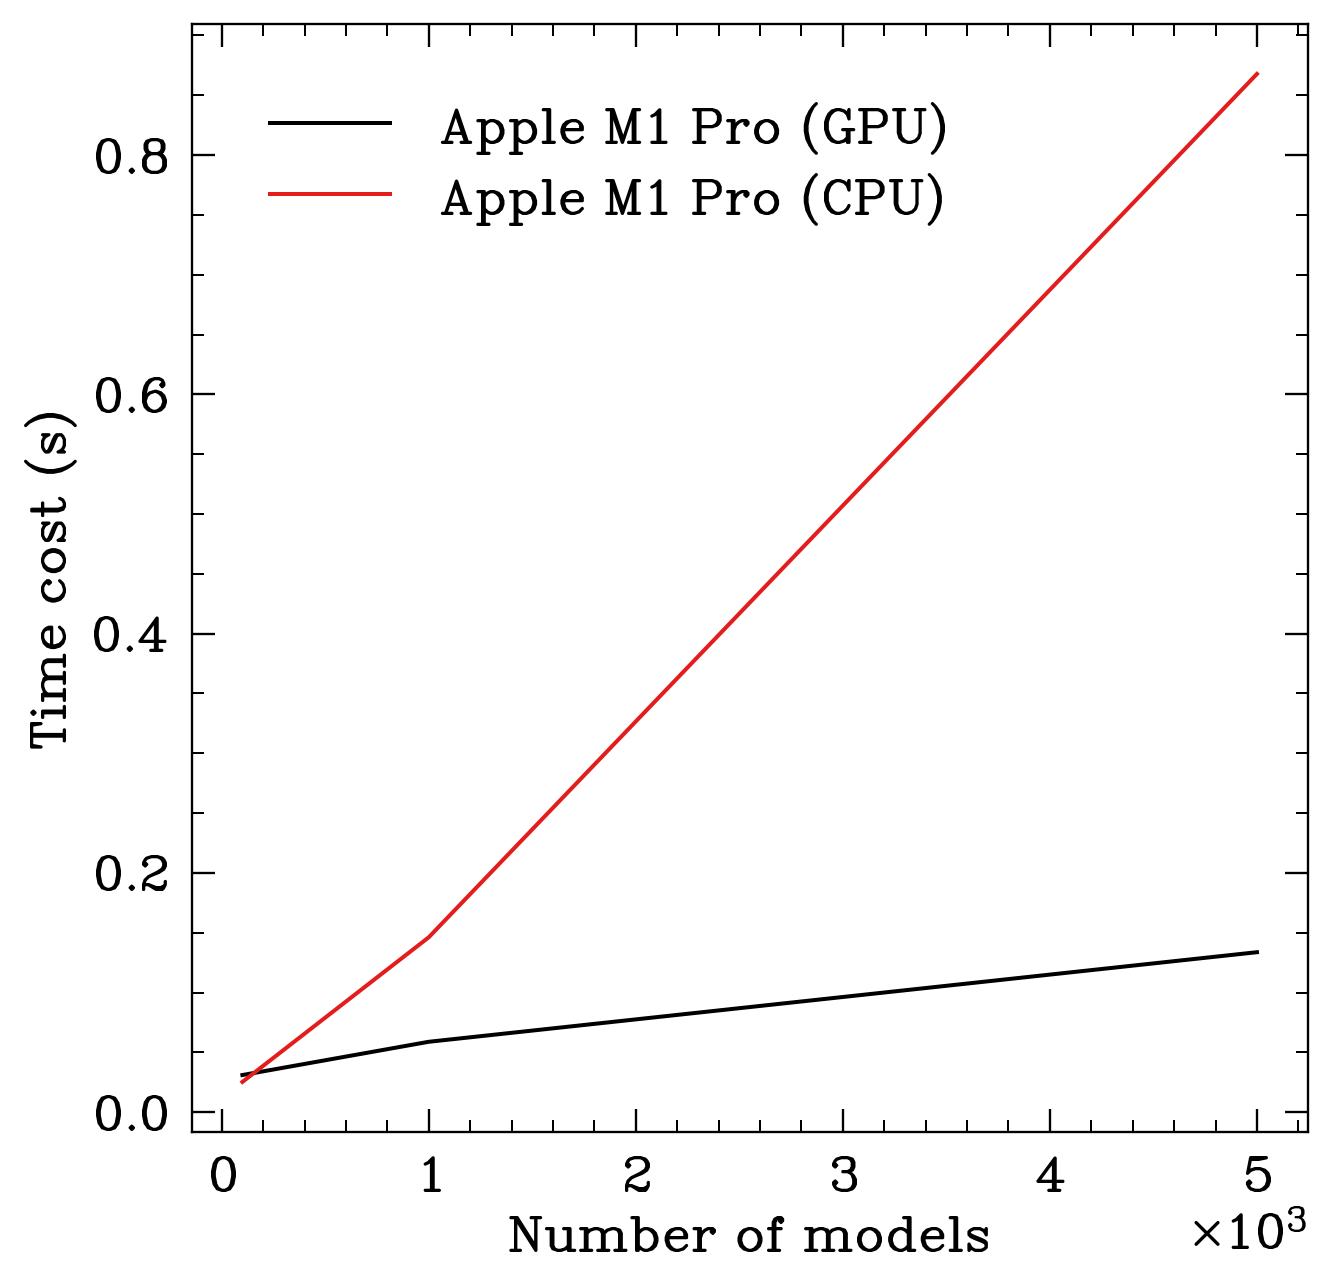

In [8]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import cmasher as cmr
import smplotlib

# set default font size
plt.rcParams['font.size'] = 18
plt.plot(num_models_list[1:], time_cost_mps[1:], label='Apple M1 Pro (GPU)')
plt.plot(num_models_list[1:], time_cost_cpu[1:], label='Apple M1 Pro (CPU)')
plt.xlabel('Number of models')
plt.ylabel('Time cost (s)')
plt.legend()
plt.show()

In [2]:
atmosphere.keys()  # Check available keys in the atmosphere dictionary


dict_keys(['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'TAU'])

In [3]:
import numpy as np
# ====> DEFINE YOUR CUSTOM Teff GRID HERE <====
# Provide a Python list or NumPy array of the specific Teff values (in Kelvin)
# you want to simulate.
teff_grid_custom = np.linspace(3000, 10000, 1000) # Example: 5 values from 3000K to 9000K
# Examples:
# teff_grid_custom = [3000.0, 6000.0, 9000.0] # A simple list
# teff_grid_custom = np.array([4000, 4500, 5000, 5500, 6000], dtype=np.float32) # Using numpy

# Define the *fixed* other stellar parameters - these will be used for ALL Teff values
logg_val = 4.5
feh_val = -0.5
alpha_fe_val = 0.0

# Define optical depth grid parameters (should match the original code/model training)
num_depth_points = 80
tau_min_log = -6
tau_max_log = 2
# --- End Configuration ---
# --- Prepare Inputs ---

# 1. Create the Teff tensor directly from your custom grid
teff_values = torch.tensor(teff_grid_custom, dtype=torch.float32)

# 2. Create the batch of stellar parameters based on the custom Teff grid
batch_size = len(teff_values) # The batch size is now the number of Teff values you provided

# Create tensors for the constant parameters, matching the size of the Teff tensor
logg_tensor = torch.full((batch_size,), logg_val, dtype=torch.float32)
feh_tensor = torch.full((batch_size,), feh_val, dtype=torch.float32)
alpha_fe_tensor = torch.full((batch_size,), alpha_fe_val, dtype=torch.float32)

# Stack the parameter tensors column-wise to create the final batch
# Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]] for each custom Teff
stellar_params_batch = torch.stack(
    [teff_values, logg_tensor, feh_tensor, alpha_fe_tensor],
    dim=1 # Stack along the second dimension
)
print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")

# 3. Create optical depth grid
# Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
print(f"Using tau_grid with shape: {tau_grid.shape}")


# --- Predict Atmospheric Structures for the Batch ---
print("\nPredicting atmospheric structures for the custom Teff grid...")

with torch.no_grad():
    atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
print("Prediction complete.")

# --- Access and Use Results ---
# The results are dictionaries containing tensors for the whole batch.
# T and P will have shape: [batch_size, num_depth_points]
rho_batch = atmosphere_batch['RHOX']  # Density
temperatures_batch = atmosphere_batch['T']
pressures_batch = atmosphere_batch['P']
xne_batch = atmosphere_batch['XNE']
kappa_batch = atmosphere_batch['ABROSS']

Created stellar parameter batch with shape: torch.Size([1000, 4])
Using tau_grid with shape: torch.Size([1, 80])

Predicting atmospheric structures for the custom Teff grid...
Prediction complete.



Generating plots...


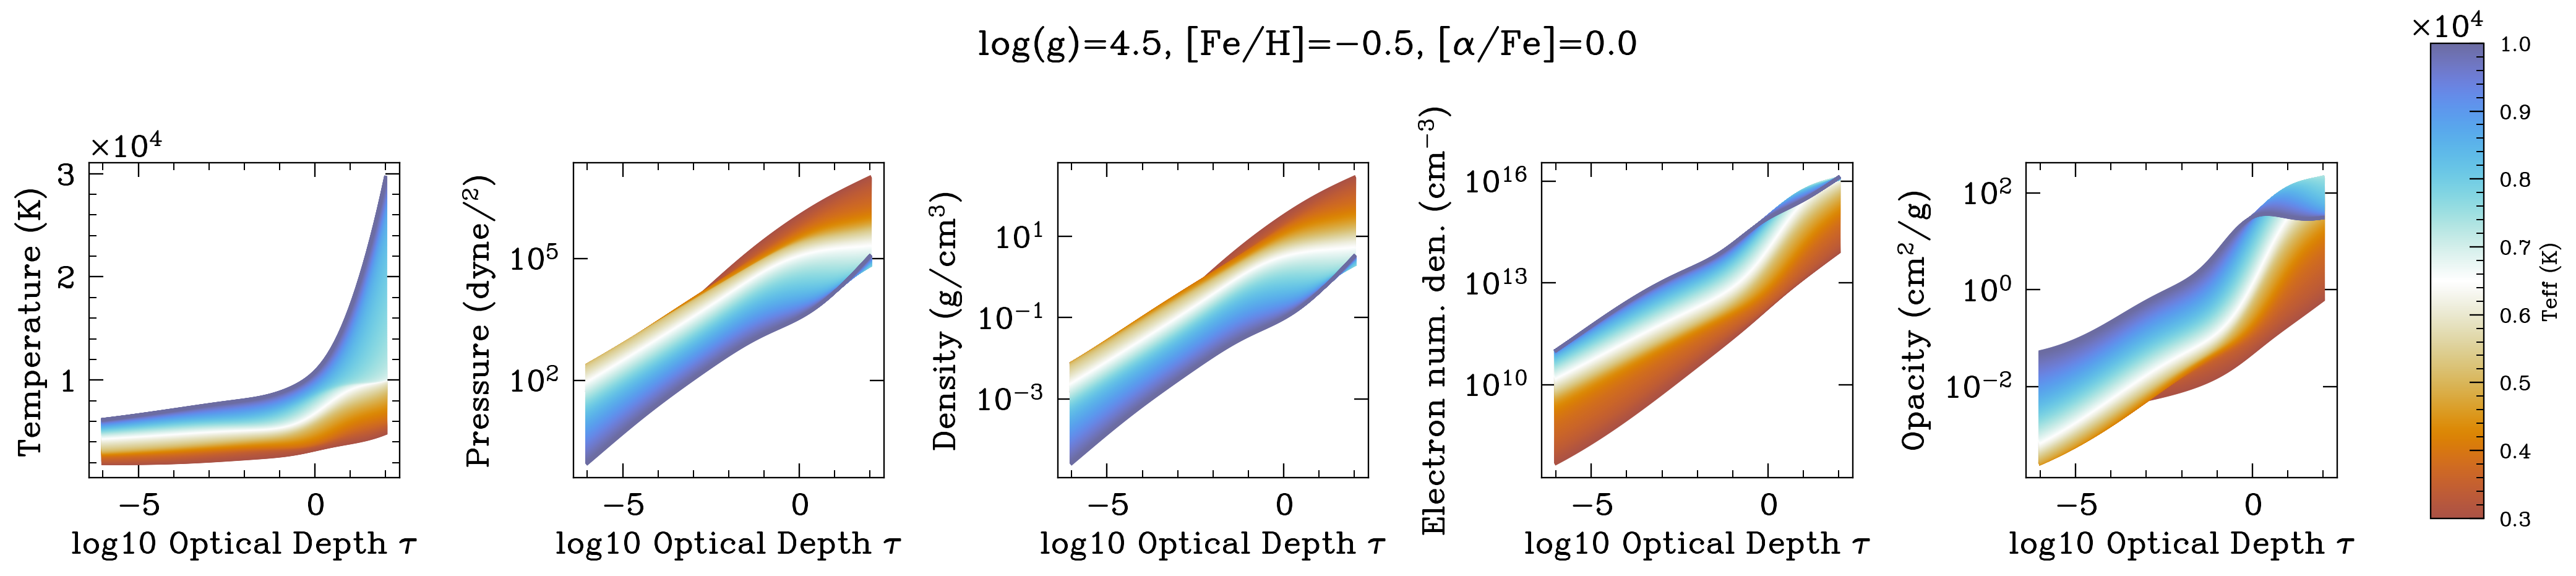

In [39]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import cmasher as cmr
import smplotlib
# set default font size
plt.rcParams['font.size'] = 18

teff_values_np = teff_values.numpy()  # Convert to NumPy for plotting
# --- Plotting Section ---
print("\nGenerating plots...")

# Define the variables to plot, their labels, and if Y-axis should be log scale
variables_to_plot = {
    'Temperature': {'data': temperatures_batch, 'label': 'Temperature (K)', 'logy': False},
    'Pressure': {'data': pressures_batch, 'label':  r'Pressure (dyne/$^2$)', 'logy': True},
    'Density': {'data': rho_batch, 'label': r'Density (g/cm$^3$)', 'logy': True},
    'Electron Density': {'data': xne_batch, 'label': r'Electron num. den. (cm$^{-3}$)', 'logy': True}, # XNE might need log scale
    'Opacity': {'data': kappa_batch, 'label': r'Opacity (cm$^2$/g)', 'logy': True}
}
plot_keys = list(variables_to_plot.keys())

# Calculate log10(tau) for the x-axis
log_tau_values_np = np.log10(tau_grid.numpy()).flatten()  # Flatten to 1D for plotting

# Set up colormap and normalization for Teff
cmap = plt.get_cmap('cmr.prinsenvlag')  # Using 'plasma' colormap
norm = colors.Normalize(vmin=teff_values.min(), vmax=teff_values.max())

# Create figure and axes (5 rows, 1 column)
fig, axes = plt.subplots(1, len(plot_keys), figsize=(18, 4))

# Loop through each variable and plot it on its corresponding subplot
for i, key in enumerate(plot_keys):
    ax = axes[i]
    var_info = variables_to_plot[key]
    data_batch = var_info['data']
    ylabel = var_info['label']
    use_log_y = var_info['logy']

    # Plot data for each Teff
    for teff_idx in range(batch_size):
        color = cmap(norm(teff_values_np[teff_idx]))
        ax.plot(log_tau_values_np, data_batch[teff_idx, :], color=color, alpha=0.85, linewidth=1.5)

    # Configure subplot
    ax.set_ylabel(ylabel)
    if use_log_y:
        ax.set_yscale('log')


    ax.set_xlabel(r'log10 Optical Depth $\tau$')

    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    # ax.set_title(key) # Title on each subplot can be redundant with y-label

# Set x-axis label only on the bottom plot
# axes[-1].set_xlabel('log10(Optical Depth, tau)')

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needed for standalone colorbar

# Create a new axis for the colorbar and position it to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Teff (K)', fontsize=12) # Increased colorbar label font size
cbar.ax.tick_params(labelsize=12) # Set colorbar tick label size

# Add overall figure title
fig.suptitle(f'log(g)={logg_val}, [Fe/H]={feh_val}, [α/Fe]={alpha_fe_val}', fontsize=20) # Increased suptitle font size

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbar
plt.show()

fig.savefig(f'fig/emulate_teff.pdf', dpi=300)

Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])
Prediction complete.

Generating plots...


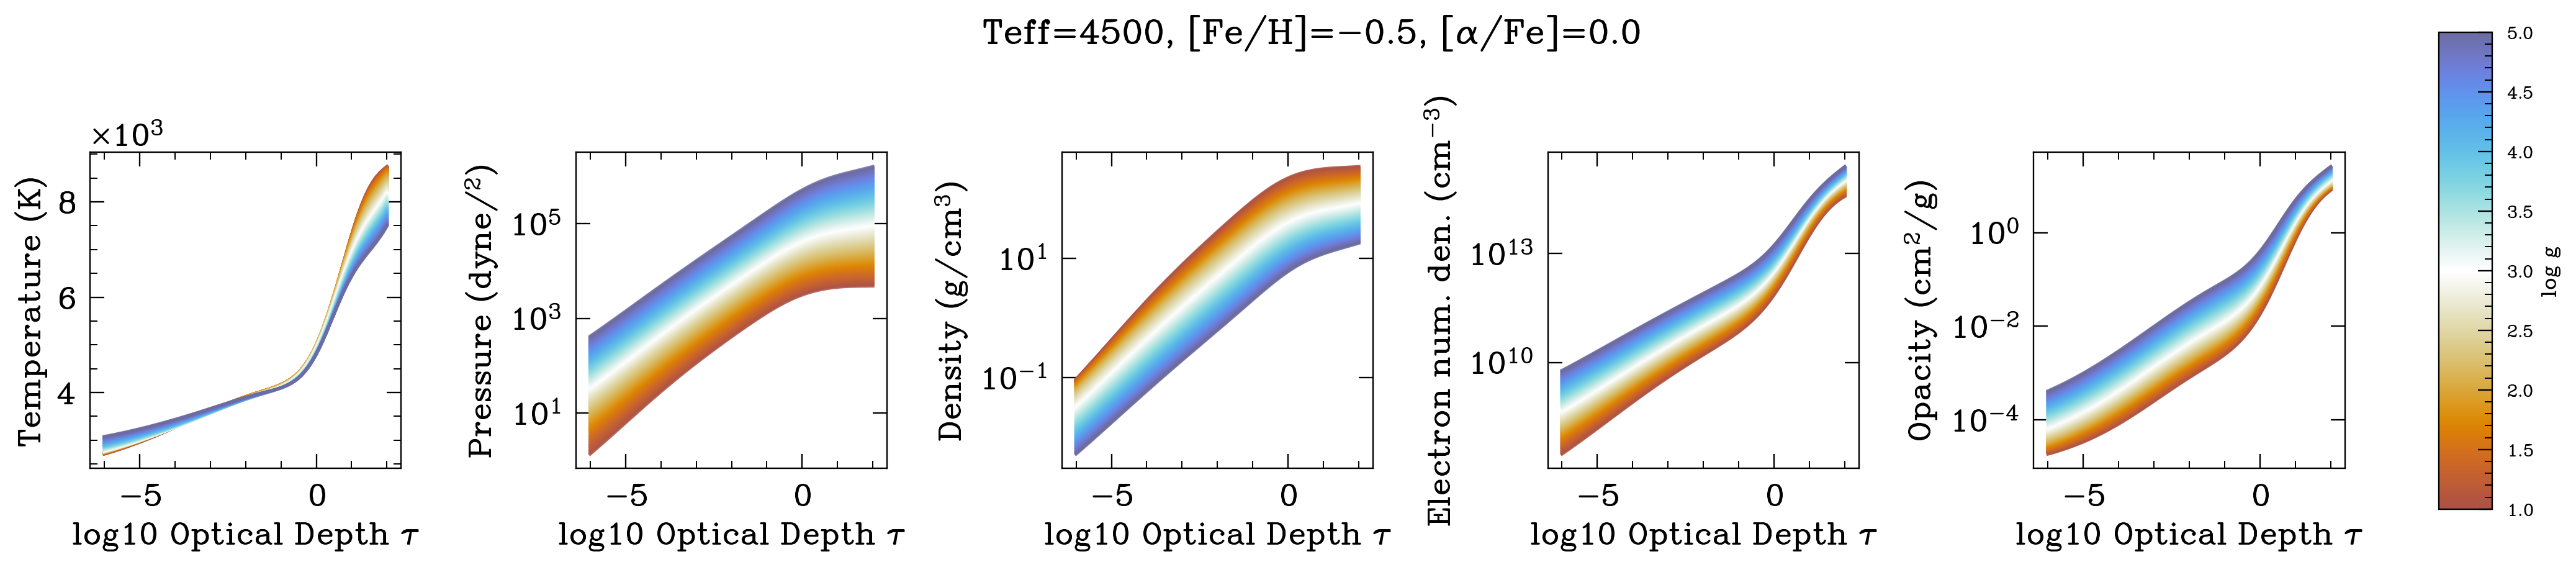

In [40]:
# ====> DEFINE YOUR CUSTOM Teff GRID HERE <====
# Provide a Python list or NumPy array of the specific Teff values (in Kelvin)
# you want to simulate.

# Define the *fixed* other stellar parameters - these will be used for ALL Teff values
teff_val = 4500
logg_val = np.linspace(1.0, 5.0, 100)  # Example: 100 values from 4.0 to 5.0
feh_val = -0.5
alpha_fe_val = 0.0

# Define optical depth grid parameters (should match the original code/model training)
num_depth_points = 80
tau_min_log = -6
tau_max_log = 2
# --- End Configuration ---
# --- Prepare Inputs ---

# 1. Create the Teff tensor directly from your custom grid
logg_values = torch.tensor(logg_val, dtype=torch.float32)
# 2. Create the batch of stellar parameters based on the custom Teff grid
batch_size = len(logg_values) # The batch size is now the number of Teff values you provided

# Create tensors for the constant parameters, matching the size of the Teff tensor
teff_tensor = torch.full((batch_size,), teff_val, dtype=torch.float32)
feh_tensor = torch.full((batch_size,), feh_val, dtype=torch.float32)
alpha_fe_tensor = torch.full((batch_size,), alpha_fe_val, dtype=torch.float32)

# Stack the parameter tensors column-wise to create the final batch
# Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]] for each custom Teff
stellar_params_batch = torch.stack(
    [teff_tensor, logg_values, feh_tensor, alpha_fe_tensor],
    dim=1 # Stack along the second dimension
)
print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")

# 3. Create optical depth grid
# Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
print(f"Using tau_grid with shape: {tau_grid.shape}")

with torch.no_grad():
    atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
print("Prediction complete.")

# --- Access and Use Results ---
# The results are dictionaries containing tensors for the whole batch.
# T and P will have shape: [batch_size, num_depth_points]
rho_batch = atmosphere_batch['RHOX']  # Density
temperatures_batch = atmosphere_batch['T']
pressures_batch = atmosphere_batch['P']
xne_batch = atmosphere_batch['XNE']
kappa_batch = atmosphere_batch['ABROSS']

teff_values_np = teff_values.numpy()  # Convert to NumPy for plotting
# --- Plotting Section ---
print("\nGenerating plots...")
variables_to_plot = {
    'Temperature': {'data': temperatures_batch, 'label': 'Temperature (K)', 'logy': False},
    'Pressure': {'data': pressures_batch, 'label':  r'Pressure (dyne/$^2$)', 'logy': True},
    'Density': {'data': rho_batch, 'label': r'Density (g/cm$^3$)', 'logy': True},
    'Electron Density': {'data': xne_batch, 'label': r'Electron num. den. (cm$^{-3}$)', 'logy': True}, # XNE might need log scale
    'Opacity': {'data': kappa_batch, 'label': r'Opacity (cm$^2$/g)', 'logy': True}
}

plot_keys = list(variables_to_plot.keys())

# Calculate log10(tau) for the x-axis
log_tau_values_np = np.log10(tau_grid.numpy()).flatten()  # Flatten to 1D for plotting

# Set up colormap and normalization for Teff
cmap = plt.get_cmap('cmr.prinsenvlag')  # Using 'plasma' colormap
norm = colors.Normalize(vmin=logg_values.min(), vmax=logg_values.max())

# Create figure and axes (5 rows, 1 column)
fig, axes = plt.subplots(1, len(plot_keys), figsize=(18, 4))

# Loop through each variable and plot it on its corresponding subplot
for i, key in enumerate(plot_keys):
    ax = axes[i]
    var_info = variables_to_plot[key]
    data_batch = var_info['data']
    ylabel = var_info['label']
    use_log_y = var_info['logy']

    # Plot data for each Teff
    for idx in range(batch_size):
        color = cmap(norm(logg_values[idx]))
        ax.plot(log_tau_values_np, data_batch[idx, :], color=color, alpha=0.85, linewidth=1.5)

    # Configure subplot
    ax.set_ylabel(ylabel)
    if use_log_y:
        ax.set_yscale('log')

    ax.set_xlabel(r'log10 Optical Depth $\tau$')

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needed for standalone colorbar

# Create a new axis for the colorbar and position it to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('log g', fontsize=12) # Increased colorbar label font size
cbar.ax.tick_params(labelsize=10) # Set colorbar tick label size

# Add overall figure title
fig.suptitle(f'Teff={teff_val}, [Fe/H]={feh_val}, [α/Fe]={alpha_fe_val}', fontsize=20) # Increased suptitle font size

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbar
plt.show()

fig.savefig("fig/emulate_logg.pdf")

Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])
Prediction complete.


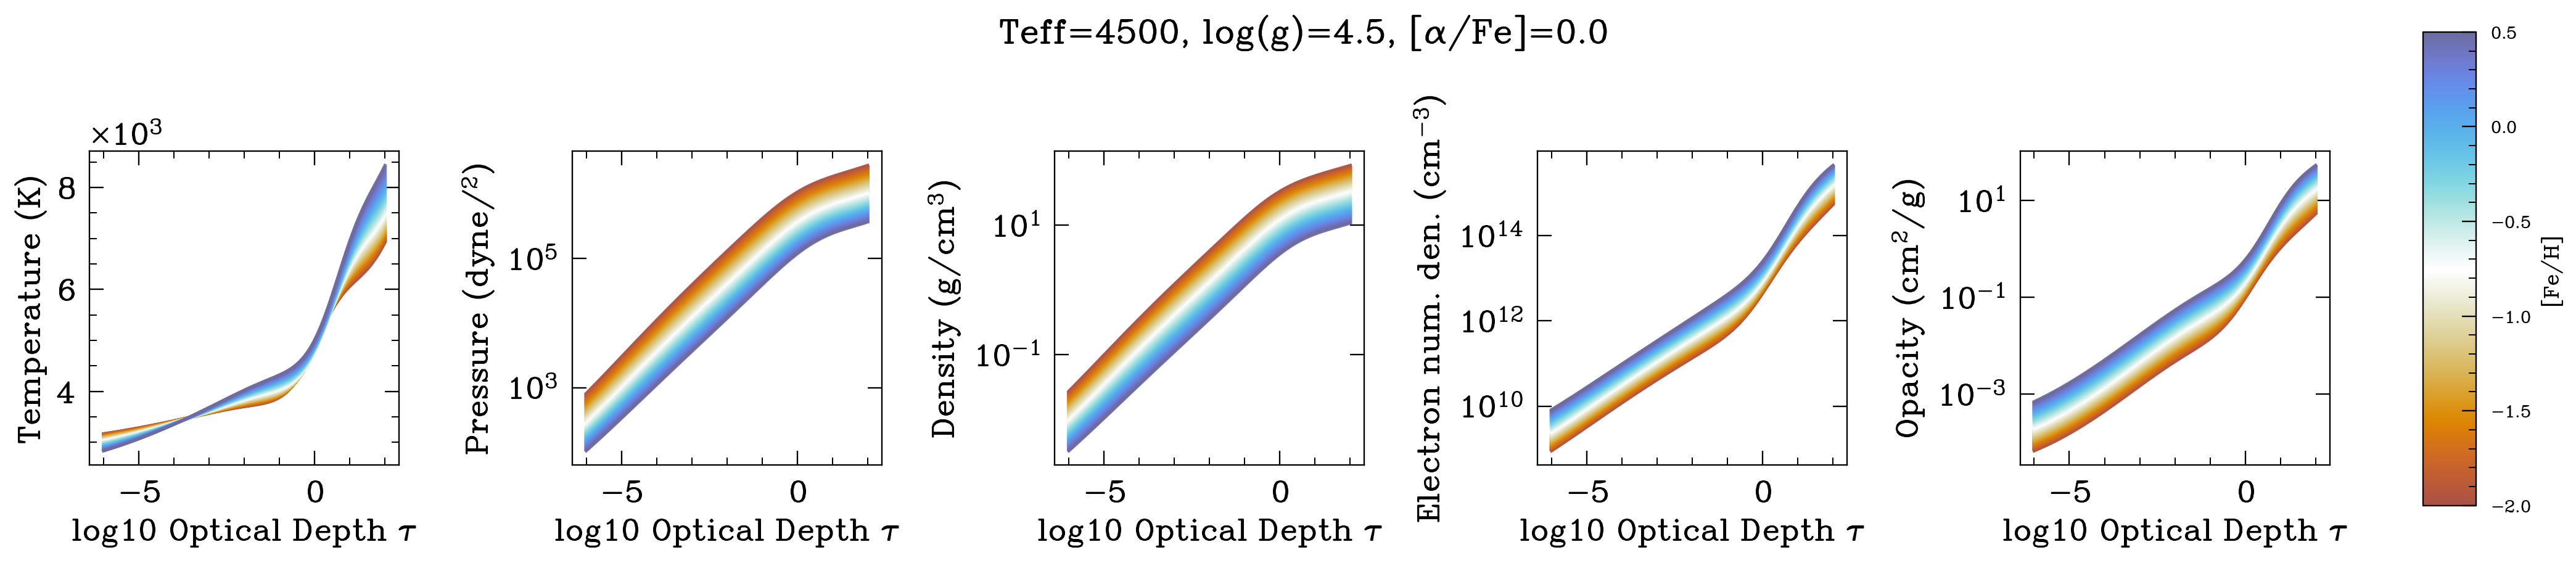

In [41]:
# ====> DEFINE YOUR CUSTOM Teff GRID HERE <====
# Provide a Python list or NumPy array of the specific Teff values (in Kelvin)
# you want to simulate.

# Define the *fixed* other stellar parameters - these will be used for ALL Teff values
teff_val = 4500
# logg_val = np.linspace(1.0, 5.0, 100)  # Example: 100 values from 4.0 to 5.0
logg_val = 4.5
feh_val = np.linspace(-2.0, 0.5, 100)  # Example: 100 values from -2.0 to 0.5
alpha_fe_val = 0.0

# Define optical depth grid parameters (should match the original code/model training)
num_depth_points = 80
tau_min_log = -6
tau_max_log = 2
# --- End Configuration ---
# --- Prepare Inputs ---

# 1. Create the Teff tensor directly from your custom grid
feh_values = torch.tensor(feh_val, dtype=torch.float32)
# 2. Create the batch of stellar parameters based on the custom Teff grid
batch_size = len(feh_values) # The batch size is now the number of Teff values you provided

# Create tensors for the constant parameters, matching the size of the Teff tensor
teff_tensor = torch.full((batch_size,), teff_val, dtype=torch.float32)
logg_tensor = torch.full((batch_size,), logg_val, dtype=torch.float32)
alpha_fe_tensor = torch.full((batch_size,), alpha_fe_val, dtype=torch.float32)

# Stack the parameter tensors column-wise to create the final batch
# Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]] for each custom Teff
stellar_params_batch = torch.stack(
    [teff_tensor, logg_tensor, feh_values, alpha_fe_tensor],
    dim=1 # Stack along the second dimension
)
print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")

# 3. Create optical depth grid
# Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
print(f"Using tau_grid with shape: {tau_grid.shape}")

with torch.no_grad():
    atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
print("Prediction complete.")

# --- Access and Use Results ---
# The results are dictionaries containing tensors for the whole batch.
# T and P will have shape: [batch_size, num_depth_points]
rho_batch = atmosphere_batch['RHOX']  # Density
temperatures_batch = atmosphere_batch['T']
pressures_batch = atmosphere_batch['P']
xne_batch = atmosphere_batch['XNE']
kappa_batch = atmosphere_batch['ABROSS']

variables_to_plot = {
    'Temperature': {'data': temperatures_batch, 'label': 'Temperature (K)', 'logy': False},
    'Pressure': {'data': pressures_batch, 'label':  r'Pressure (dyne/$^2$)', 'logy': True},
    'Density': {'data': rho_batch, 'label': r'Density (g/cm$^3$)', 'logy': True},
    'Electron Density': {'data': xne_batch, 'label': r'Electron num. den. (cm$^{-3}$)', 'logy': True}, # XNE might need log scale
    'Opacity': {'data': kappa_batch, 'label': r'Opacity (cm$^2$/g)', 'logy': True}
}
plot_keys = list(variables_to_plot.keys())

# Calculate log10(tau) for the x-axis
log_tau_values_np = np.log10(tau_grid.numpy()).flatten()  # Flatten to 1D for plotting

# Set up colormap and normalization for Teff
cmap = plt.get_cmap('cmr.prinsenvlag')  # Using 'plasma' colormap
norm = colors.Normalize(vmin=feh_values.min(), vmax=feh_values.max())

# Create figure and axes (5 rows, 1 column)
fig, axes = plt.subplots(1, len(plot_keys), figsize=(18, 4))

# Loop through each variable and plot it on its corresponding subplot
for i, key in enumerate(plot_keys):
    ax = axes[i]
    var_info = variables_to_plot[key]
    data_batch = var_info['data']
    ylabel = var_info['label']
    use_log_y = var_info['logy']

    # Plot data for each Teff
    for idx in range(batch_size):
        color = cmap(norm(feh_values[idx]))
        ax.plot(log_tau_values_np, data_batch[idx, :], color=color, alpha=0.85, linewidth=1.5)

    # Configure subplot
    ax.set_ylabel(ylabel)
    if use_log_y:
        ax.set_yscale('log')

    ax.set_xlabel(r'log10 Optical Depth $\tau$')

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needed for standalone colorbar

# Create a new axis for the colorbar and position it to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('[Fe/H]', fontsize=12) # Increased colorbar label font size
cbar.ax.tick_params(labelsize=10) # Set colorbar tick label size

# Add overall figure title
fig.suptitle(f'Teff={teff_val}, log(g)={logg_val}, [α/Fe]={alpha_fe_val}', fontsize=20) # Increased suptitle font size

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbar
plt.show()

fig.savefig("fig/emulate_feh.pdf")

Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])
Prediction complete.


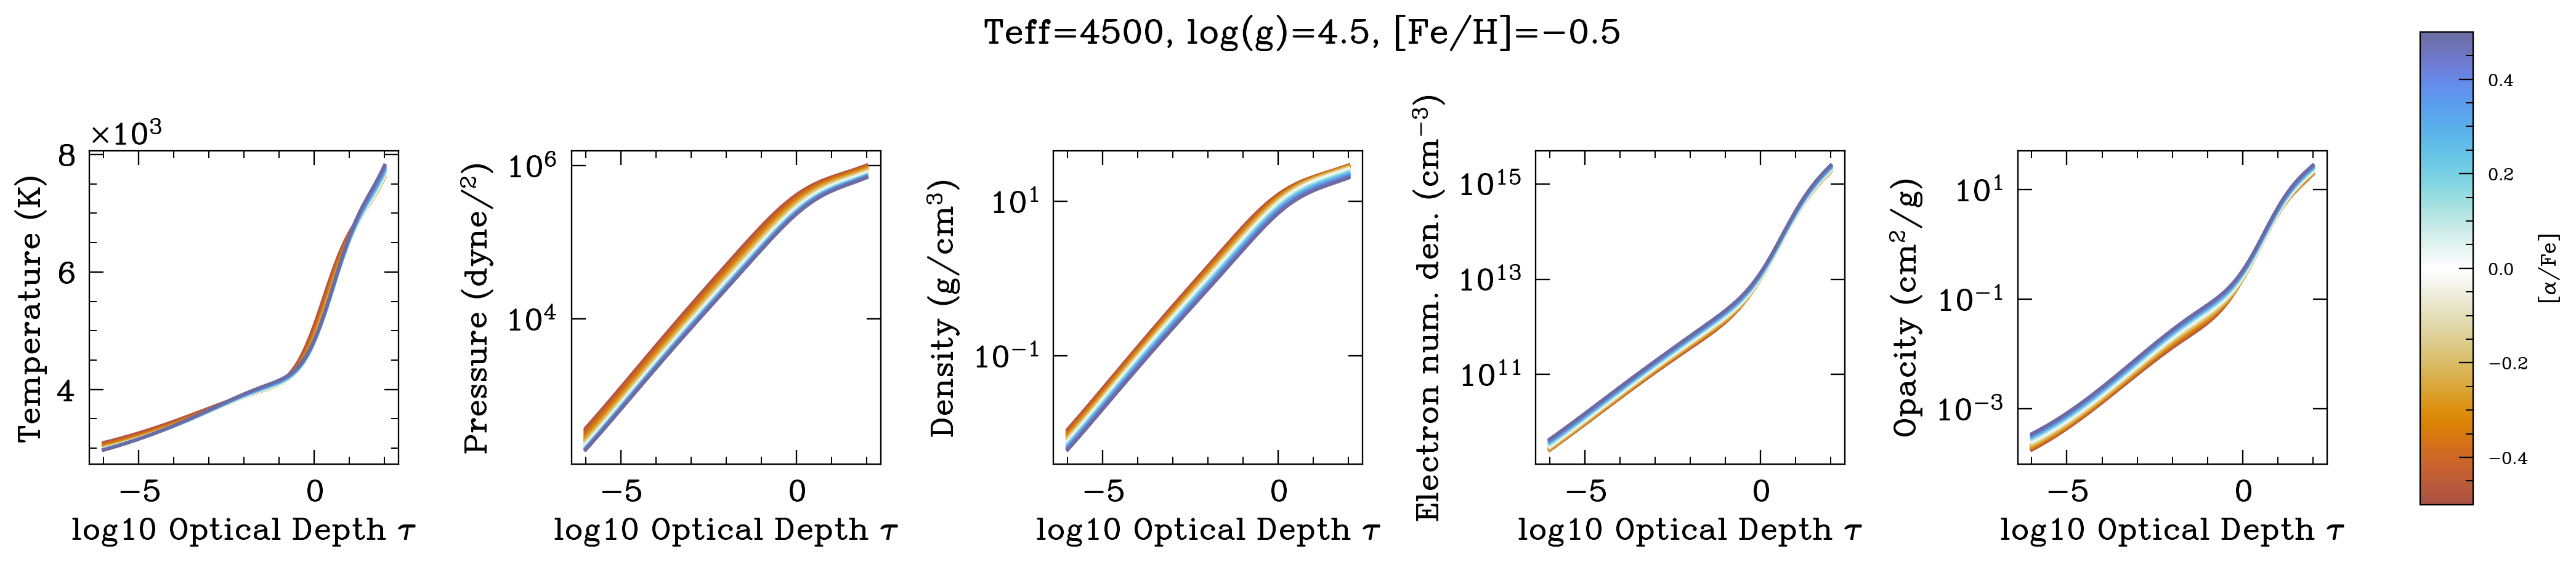

In [42]:
# ====> DEFINE YOUR CUSTOM Teff GRID HERE <====
# Provide a Python list or NumPy array of the specific Teff values (in Kelvin)
# you want to simulate.

# Define the *fixed* other stellar parameters - these will be used for ALL Teff values
teff_val = 4500
# logg_val = np.linspace(1.0, 5.0, 100)  # Example: 100 values from 4.0 to 5.0
logg_val = 4.5
feh_val = -0.5
afe_val = np.linspace(-0.5, 0.5, 100)  # Example: 100 values from -0.5 to 0.5

# Define optical depth grid parameters (should match the original code/model training)
num_depth_points = 80
tau_min_log = -6
tau_max_log = 2
# --- End Configuration ---
# --- Prepare Inputs ---

# 1. Create the Teff tensor directly from your custom grid
afe_values = torch.tensor(afe_val, dtype=torch.float32)
# 2. Create the batch of stellar parameters based on the custom Teff grid
batch_size = len(afe_values) # The batch size is now the number of Teff values you provided

# Create tensors for the constant parameters, matching the size of the Teff tensor
teff_tensor = torch.full((batch_size,), teff_val, dtype=torch.float32)
logg_tensor = torch.full((batch_size,), logg_val, dtype=torch.float32)
feh_values = torch.full((batch_size,), feh_val, dtype=torch.float32)

# Stack the parameter tensors column-wise to create the final batch
# Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]] for each custom Teff
stellar_params_batch = torch.stack(
    [teff_tensor, logg_tensor, feh_values, afe_values],
    dim=1 # Stack along the second dimension
)
print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")

# 3. Create optical depth grid
# Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
print(f"Using tau_grid with shape: {tau_grid.shape}")

with torch.no_grad():
    atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
print("Prediction complete.")

# --- Access and Use Results ---
# The results are dictionaries containing tensors for the whole batch.
# T and P will have shape: [batch_size, num_depth_points]
rho_batch = atmosphere_batch['RHOX']  # Density
temperatures_batch = atmosphere_batch['T']
pressures_batch = atmosphere_batch['P']
xne_batch = atmosphere_batch['XNE']
kappa_batch = atmosphere_batch['ABROSS']
variables_to_plot = {
    'Temperature': {'data': temperatures_batch, 'label': 'Temperature (K)', 'logy': False},
    'Pressure': {'data': pressures_batch, 'label':  r'Pressure (dyne/$^2$)', 'logy': True},
    'Density': {'data': rho_batch, 'label': r'Density (g/cm$^3$)', 'logy': True},
    'Electron Density': {'data': xne_batch, 'label': r'Electron num. den. (cm$^{-3}$)', 'logy': True}, # XNE might need log scale
    'Opacity': {'data': kappa_batch, 'label': r'Opacity (cm$^2$/g)', 'logy': True}
}
plot_keys = list(variables_to_plot.keys())

# Calculate log10(tau) for the x-axis
log_tau_values_np = np.log10(tau_grid.numpy()).flatten()  # Flatten to 1D for plotting

# Set up colormap and normalization for Teff
cmap = plt.get_cmap('cmr.prinsenvlag')  # Using 'plasma' colormap
norm = colors.Normalize(vmin=afe_values.min(), vmax=afe_values.max())

# Create figure and axes (5 rows, 1 column)
fig, axes = plt.subplots(1, len(plot_keys), figsize=(18, 4))

# Loop through each variable and plot it on its corresponding subplot
for i, key in enumerate(plot_keys):
    ax = axes[i]
    var_info = variables_to_plot[key]
    data_batch = var_info['data']
    ylabel = var_info['label']
    use_log_y = var_info['logy']

    # Plot data for each Teff
    for idx in range(batch_size):
        color = cmap(norm(afe_values[idx]))
        ax.plot(log_tau_values_np, data_batch[idx, :], color=color, alpha=0.85, linewidth=1.5)

    # Configure subplot
    ax.set_ylabel(ylabel)
    if use_log_y:
        ax.set_yscale('log')

    ax.set_xlabel(r'log10 Optical Depth $\tau$')

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needed for standalone colorbar

# Create a new axis for the colorbar and position it to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'[$\alpha$/Fe]', fontsize=12) # Increased colorbar label font size
cbar.ax.tick_params(labelsize=10) # Set colorbar tick label size

# Add overall figure title
fig.suptitle(f'Teff={teff_val}, log(g)={logg_val}, [Fe/H]={feh_val}', fontsize=20) # Increased suptitle font size

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbar
plt.show()

fig.savefig("fig/emulate_afe.pdf")

# plot figure

In [6]:
import numpy as np
import torch

def predict_stellar_atmospheres(
    model,
    teff_grid=None,
    logg_grid=None,
    feh_grid=None,
    alpha_fe_grid=None,
    num_depth_points=80,
    tau_min_log=-6,
    tau_max_log=2
):
    """
    Predict atmospheric structures for a grid of stellar parameters.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model for stellar atmosphere prediction.
    teff_grid : array-like, optional
        Grid of effective temperatures in Kelvin.
        If None, a default grid from 3000K to 10000K with 1000 points will be used.
    logg_grid : array-like, optional
        Grid of log surface gravity values.
        If None, a default value of 4.5 will be used for all points.
    feh_grid : array-like, optional
        Grid of metallicity [Fe/H] values.
        If None, a default value of -0.5 will be used for all points.
    alpha_fe_grid : array-like, optional
        Grid of alpha enhancement [α/Fe] values.
        If None, a default value of 0.0 will be used for all points.
    num_depth_points : int, default=80
        Number of optical depth points.
    tau_min_log : float, default=-6
        Minimum log10 optical depth.
    tau_max_log : float, default=2
        Maximum log10 optical depth.
        
    Returns:
    --------
    dict
        Dictionary containing the predicted atmospheric structures with keys:
        'RHOX', 'T', 'P', 'XNE', 'ABROSS' corresponding to density, temperature,
        pressure, electron number density, and Rosseland mean opacity, respectively.
    tuple
        (stellar_params_batch, atmosphere_batch) - Returns both the input parameters
        and the resulting atmospheric structures for reference.
    """
    # Use default Teff grid if none provided
    if teff_grid is None:
        teff_grid = np.linspace(3000, 10000, 1000)
    
    # Set up default grids for other parameters if not provided
    batch_size = len(teff_grid)
    
    if logg_grid is None:
        logg_grid = np.full(batch_size, 4.5)
    if feh_grid is None:
        feh_grid = np.full(batch_size, -0.5)
    if alpha_fe_grid is None:
        alpha_fe_grid = np.full(batch_size, 0.0)
    
    # Ensure all grids have the same length
    if not (len(logg_grid) == len(feh_grid) == len(alpha_fe_grid) == batch_size):
        raise ValueError("All parameter grids must have the same length")
    
    # 1. Create tensors from the parameter grids
    teff_values = torch.tensor(teff_grid, dtype=torch.float32)
    logg_values = torch.tensor(logg_grid, dtype=torch.float32)
    feh_values = torch.tensor(feh_grid, dtype=torch.float32)
    alpha_fe_values = torch.tensor(alpha_fe_grid, dtype=torch.float32)
    
    # 2. Stack the parameter tensors column-wise to create the final batch
    # Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]]
    stellar_params_batch = torch.stack(
        [teff_values, logg_values, feh_values, alpha_fe_values],
        dim=1
    )
    print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")
    
    # 3. Create optical depth grid
    # Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
    tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
    print(f"Using tau_grid with shape: {tau_grid.shape}")
    
    # --- Predict Atmospheric Structures for the Batch ---
    print("\nPredicting atmospheric structures for the parameter grid...")
    
    with torch.no_grad():
        atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
    print("Prediction complete.")
    
    return atmosphere_batch


In [7]:
import numpy as np
import torch

def generate_atmosphere_grids(model, num_points=80):
    """
    Generate 4 separate atmospheric structure grids, each varying only one parameter,
    and include parameter metadata for plotting.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model for stellar atmosphere prediction.
    num_points : int, default=100
        Number of points in each grid.

    Returns:
    --------
    dict
        Dictionary containing the 4 atmospheric structure grids with keys:
        'teff_grid', 'logg_grid', 'feh_grid', 'afe_grid'. Each value is a
        dictionary containing the predicted structures ('T', 'P', etc.) AND
        a 'params' dictionary with 'values', 'label', and 'fixed' info.
    """
    results = {}

    # Common fixed parameters
    default_teff = 4500
    default_logg = 4.5
    default_feh = -0.5
    default_afe = 0.0

    # --- Grid 1: Vary Teff only ---
    print("\n=== Grid 1: Varying Effective Temperature ===")
    teff_values = np.linspace(4000, 8000, num_points)
    logg_values_fixed = np.full(num_points, default_logg)
    feh_values_fixed = np.full(num_points, default_feh)
    afe_values_fixed = np.full(num_points, default_afe)

    predictions_teff = predict_stellar_atmospheres(
        model,
        teff_grid=teff_values,
        logg_grid=logg_values_fixed,
        feh_grid=feh_values_fixed,
        alpha_fe_grid=afe_values_fixed
    )
    # Add parameter metadata
    predictions_teff['params'] = {
        'values': teff_values,
        'label': 'Teff (K)',
        'fixed': f'log(g)={default_logg}, [Fe/H]={default_feh}, [α/Fe]={default_afe}'
    }
    results['teff_grid'] = predictions_teff

    # --- Grid 2: Vary logg only ---
    print("\n=== Grid 2: Varying Surface Gravity ===")
    teff_values_fixed = np.full(num_points, default_teff)
    logg_values = np.linspace(1.0, 5.0, num_points)
    feh_values_fixed = np.full(num_points, default_feh)
    afe_values_fixed = np.full(num_points, default_afe)

    predictions_logg = predict_stellar_atmospheres(
        model,
        teff_grid=teff_values_fixed,
        logg_grid=logg_values,
        feh_grid=feh_values_fixed,
        alpha_fe_grid=afe_values_fixed
    )
    # Add parameter metadata
    predictions_logg['params'] = {
        'values': logg_values,
        'label': 'log(g)',
        'fixed': f'Teff={default_teff}K, [Fe/H]={default_feh}, [α/Fe]={default_afe}'
    }
    results['logg_grid'] = predictions_logg

    # --- Grid 3: Vary [Fe/H] only ---
    print("\n=== Grid 3: Varying Metallicity ===")
    teff_values_fixed = np.full(num_points, default_teff)
    logg_values_fixed = np.full(num_points, default_logg)
    feh_values = np.linspace(-2.0, 0.5, num_points)
    afe_values_fixed = np.full(num_points, default_afe)

    predictions_feh = predict_stellar_atmospheres(
        model,
        teff_grid=teff_values_fixed,
        logg_grid=logg_values_fixed,
        feh_grid=feh_values,
        alpha_fe_grid=afe_values_fixed
    )
    # Add parameter metadata
    predictions_feh['params'] = {
        'values': feh_values,
        'label': '[Fe/H]',
        'fixed': f'Teff={default_teff}K, log(g)={default_logg}, [α/Fe]={default_afe}'
    }
    results['feh_grid'] = predictions_feh

    # --- Grid 4: Vary [α/Fe] only ---
    print("\n=== Grid 4: Varying Alpha Enhancement ===")
    teff_values_fixed = np.full(num_points, default_teff)
    logg_values_fixed = np.full(num_points, default_logg)
    feh_values_fixed = np.full(num_points, default_feh)
    afe_values = np.linspace(-0.5, 0.5, num_points)

    predictions_afe = predict_stellar_atmospheres(
        model,
        teff_grid=teff_values_fixed,
        logg_grid=logg_values_fixed,
        feh_grid=feh_values_fixed,
        alpha_fe_grid=afe_values
    )
    # Add parameter metadata
    predictions_afe['params'] = {
        'values': afe_values,
        'label': '[α/Fe]',
        'fixed': f'Teff={default_teff}K, log(g)={default_logg}, [Fe/H]={default_feh}'
    }
    results['afe_grid'] = predictions_afe

    print("\nAll 4 atmospheric structure grids have been generated successfully.")
    return results

def predict_stellar_atmospheres(
    model,
    teff_grid=None,
    logg_grid=None,
    feh_grid=None,
    alpha_fe_grid=None,
    num_depth_points=80,
    tau_min_log=-6,
    tau_max_log=2
):
    """
    Predict atmospheric structures for a grid of stellar parameters.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model for stellar atmosphere prediction.
    teff_grid : array-like, optional
        Grid of effective temperatures in Kelvin.
        If None, a default grid from 3000K to 10000K with 1000 points will be used.
    logg_grid : array-like, optional
        Grid of log surface gravity values.
        If None, a default value of 4.5 will be used for all points.
    feh_grid : array-like, optional
        Grid of metallicity [Fe/H] values.
        If None, a default value of -0.5 will be used for all points.
    alpha_fe_grid : array-like, optional
        Grid of alpha enhancement [α/Fe] values.
        If None, a default value of 0.0 will be used for all points.
    num_depth_points : int, default=80
        Number of optical depth points.
    tau_min_log : float, default=-6
        Minimum log10 optical depth.
    tau_max_log : float, default=2
        Maximum log10 optical depth.
        
    Returns:
    --------
    dict
        Dictionary containing the predicted atmospheric structures with keys:
        'RHOX', 'T', 'P', 'XNE', 'ABROSS' corresponding to density, temperature,
        pressure, electron number density, and Rosseland mean opacity, respectively.
    """
    # Use default Teff grid if none provided
    if teff_grid is None:
        teff_grid = np.linspace(3000, 10000, 1000)
    
    # Set up default grids for other parameters if not provided
    batch_size = len(teff_grid)
    
    if logg_grid is None:
        logg_grid = np.full(batch_size, 4.5)
    if feh_grid is None:
        feh_grid = np.full(batch_size, -0.5)
    if alpha_fe_grid is None:
        alpha_fe_grid = np.full(batch_size, 0.0)
    
    # Ensure all grids have the same length
    if not (len(logg_grid) == len(feh_grid) == len(alpha_fe_grid) == batch_size):
        raise ValueError("All parameter grids must have the same length")
    
    # 1. Create tensors from the parameter grids
    teff_values = torch.tensor(teff_grid, dtype=torch.float32)
    logg_values = torch.tensor(logg_grid, dtype=torch.float32)
    feh_values = torch.tensor(feh_grid, dtype=torch.float32)
    alpha_fe_values = torch.tensor(alpha_fe_grid, dtype=torch.float32)
    
    # 2. Stack the parameter tensors column-wise to create the final batch
    # Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]]
    stellar_params_batch = torch.stack(
        [teff_values, logg_values, feh_values, alpha_fe_values],
        dim=1
    )
    print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")
    
    # 3. Create optical depth grid
    # Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
    tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
    print(f"Using tau_grid with shape: {tau_grid.shape}")
    
    # --- Predict Atmospheric Structures for the Batch ---
    print("\nPredicting atmospheric structures for the parameter grid...")
    
    with torch.no_grad():
        atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
    print("Prediction complete.")
    
    return atmosphere_batch


# Example usage:
# Generate all 4 grids with 100 points each
grids = generate_atmosphere_grids(model, num_points=100)

# Access individual grid results
teff_results = grids['teff_grid']
logg_results = grids['logg_grid']
feh_results = grids['feh_grid']
afe_results = grids['afe_grid']




=== Grid 1: Varying Effective Temperature ===
Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])

Predicting atmospheric structures for the parameter grid...
Prediction complete.

=== Grid 2: Varying Surface Gravity ===
Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])

Predicting atmospheric structures for the parameter grid...
Prediction complete.

=== Grid 3: Varying Metallicity ===
Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])

Predicting atmospheric structures for the parameter grid...
Prediction complete.

=== Grid 4: Varying Alpha Enhancement ===
Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])

Predicting atmospheric structures for the parameter grid...
Prediction complete.

All 4 atmospheric structure grids have been generated s

In [8]:
grids.keys()

dict_keys(['teff_grid', 'logg_grid', 'feh_grid', 'afe_grid'])

In [9]:
def plot_atmosphere_grid_comparison(grids, tau_grid):
    """
    Create a grid plot comparing atmospheric properties for different parameter variations.
    """
    import matplotlib
    # Force matplotlib to NOT use LaTeX for text handling
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.use('Agg')  # Use non-interactive backend
    
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors, cm
    
    # Convert tau_grid to numpy array
    if hasattr(tau_grid, 'numpy'):
        log_tau_values = np.log10(tau_grid.numpy()).flatten()
    else:
        log_tau_values = np.log10(np.array(tau_grid)).flatten()
    
    # Define plot variables - USING SIMPLE TEXT WITHOUT SPECIAL CHARACTERS
    variables_to_plot = {
        'Temperature': {'key': 'T', 'label': 'Temperature (K)', 'logy': False},
        'Pressure': {'key': 'P', 'label': 'Pressure (dyne/cm2)', 'logy': True},
        'Density': {'key': 'RHOX', 'label': 'Density (g/cm3)', 'logy': True},
        'Electron Density': {'key': 'XNE', 'label': 'Ne (cm-3)', 'logy': True},
        'Opacity': {'key': 'ABROSS', 'label': 'kappa_R (cm2/g)', 'logy': True}
    }
    
    plot_keys = list(variables_to_plot.keys())
    num_cols = len(plot_keys)
    num_rows = len(grids)
    
    # Create figure without display
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16), sharex='col')
    
    # Ensure axes is a 2D array
    axes = np.atleast_2d(axes)
    
    # Spacing adjustment
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    
    # Loop through each grid (row)
    grid_keys_list = list(grids.keys())
    for row_idx, grid_key in enumerate(grid_keys_list):
        grid_data = grids[grid_key]
        param_config = grid_data['params']
        param_values = param_config['values']
        
        # Setup colormap
        cmap = plt.get_cmap('viridis')
        norm = colors.Normalize(vmin=min(param_values), vmax=max(param_values))
        
        row_title = f"Varying {param_config['label']} ({param_config['fixed']})"
        
        # Add row title
        # Place row title using normal text rather than LaTeX
        fig.text(0.5, 0.9 - (row_idx * 0.8/max(num_rows, 1)), 
                row_title, fontsize=16, ha='center', weight='bold')
        
        # Loop through each variable (column)
        for col_idx, key in enumerate(plot_keys):
            ax = axes[row_idx, col_idx]
            var_info = variables_to_plot[key]
            data_key = var_info['key']
            data_batch = grid_data[data_key]
            use_log_y = var_info['logy']
            
            # Plot each parameter variation
            for idx in range(len(param_values)):
                color = cmap(norm(param_values[idx]))
                ax.plot(log_tau_values, data_batch[idx], color=color, linewidth=1.5)
            
            # Configure axes
            ax.set_yscale('log' if use_log_y else 'linear')
            ax.set_ylabel(var_info['label'], fontsize=14, labelpad=15)
            
            if row_idx == 0:
                ax.set_title(key, fontsize=16)
            if row_idx == num_rows - 1:
                ax.set_xlabel('log10(tau)', fontsize=14)  # Simple text without LaTeX
            
            ax.tick_params(axis='both', labelsize=12, pad=6)
            ax.grid(True, linestyle='--', alpha=0.3)
        
        # Add colorbar
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        last_ax_pos = axes[row_idx, -1].get_position()
        cbar_left = last_ax_pos.x1 + 0.01
        cbar_ax = fig.add_axes([cbar_left, last_ax_pos.y0, 0.015, last_ax_pos.height])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label(param_config['label'], fontsize=14)
        cbar.ax.tick_params(labelsize=12)
    
    # Save figure explicitly
    plt.savefig('fig/atmospheric_structure_comparison_grids.pdf', dpi=300, bbox_inches='tight')
    
    return fig

# Usage
try:
    # Explicitly disable LaTeX in the main code too
    import matplotlib
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.use('Agg')
    
    import matplotlib.pyplot as plt
    
    fig = plot_atmosphere_grid_comparison(grids, tau_grid)
    print("Plot saved successfully")
except Exception as e:
    print(f"Error: {str(e)}")

Plot saved successfully
